In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
import lightkurve as lk
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table
from lightkurve import search_lightcurvefile
from lightkurve import search_lightcurve
from lightkurve import search_targetpixelfile
import exoplanet as xo

In [2]:
star = lk.search_lightcurve('TIC 77175217',exptime=120,author='SPOC')
star

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 04,2018,SPOC,120,77175217,0.0
1,TESS Sector 05,2018,SPOC,120,77175217,0.0
2,TESS Sector 31,2020,SPOC,120,77175217,0.0
3,TESS Sector 32,2020,SPOC,120,77175217,0.0


In [3]:
lc = star.download_all()
#lc

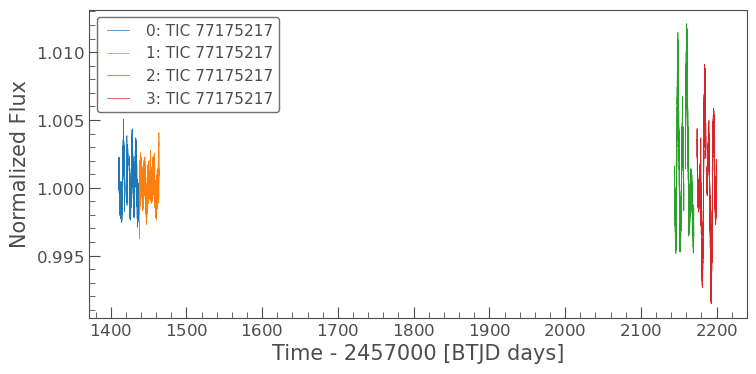

In [4]:
lc.plot(normalize=True);

Text(0.5, 1.0, 'Sector 32')

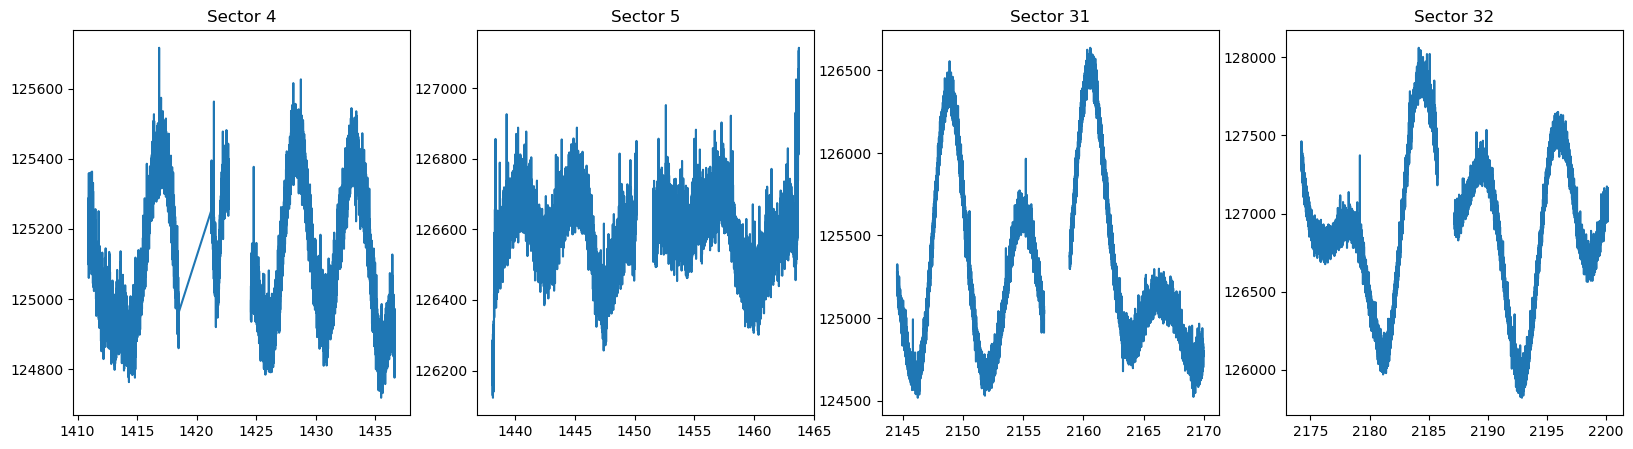

In [5]:
fig,axs = plt.subplots(1,4, figsize=(20,5), facecolor='w', edgecolor='k')
axs[0].plot(lc[0].time.btjd,lc[0].flux)
axs[0].set_title('Sector 4')

axs[1].plot(lc[1].time.btjd,lc[1].flux)
axs[1].set_title('Sector 5')
axs[2].plot(lc[2].time.btjd,lc[2].flux)
axs[2].set_title('Sector 31')
axs[3].plot(lc[3].time.btjd,lc[3].flux)
axs[3].set_title('Sector 32')

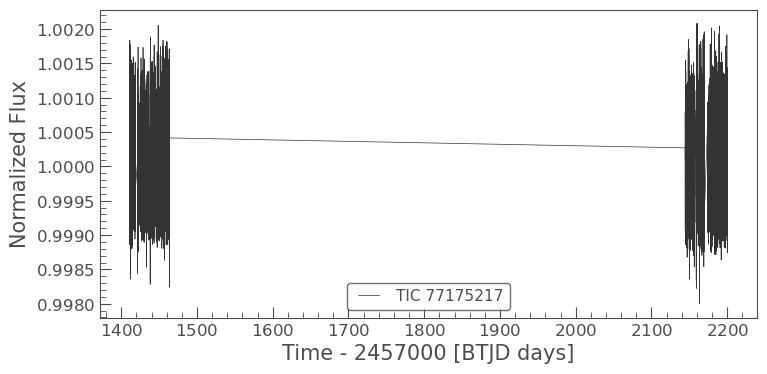

In [6]:
# Flatten the light curve
lc_flat = lc.stitch().flatten(window_length=901).remove_outliers()
lc_flat.plot();

(2174.0, 2200.0)

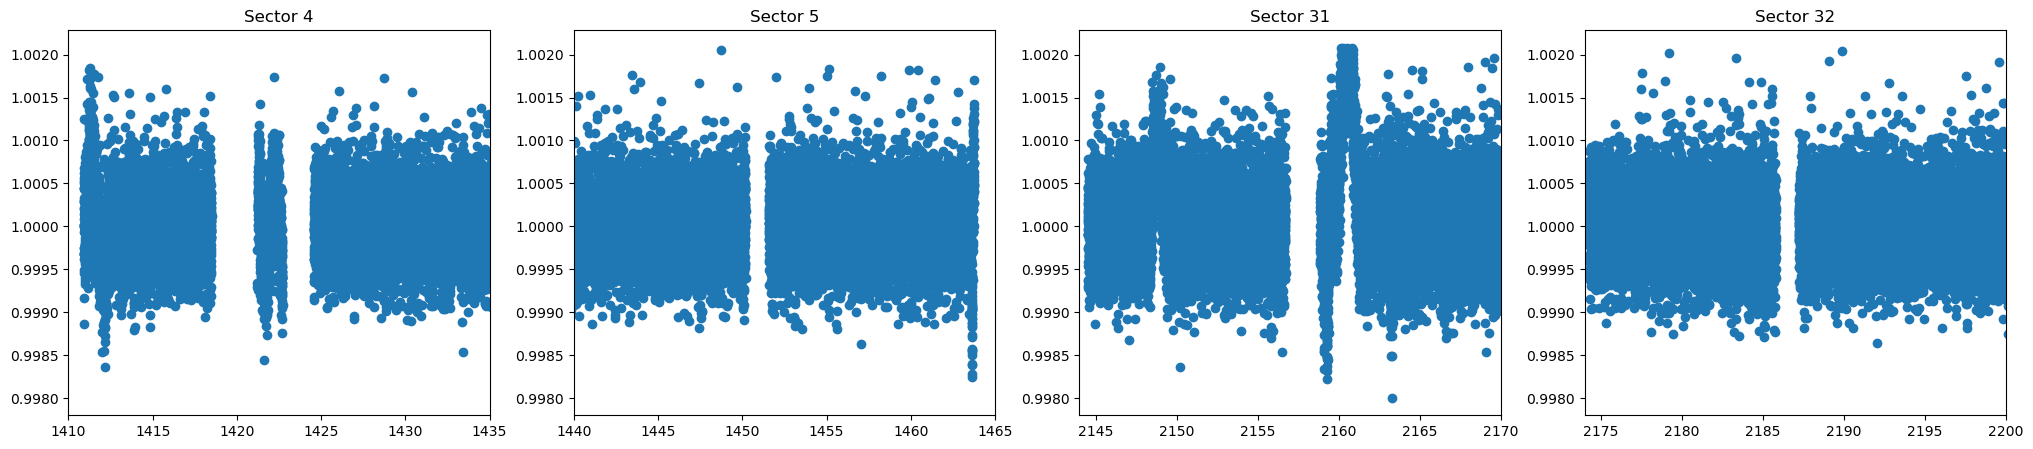

In [7]:
fig,axs = plt.subplots(1,4, figsize=(25,5), facecolor='w', edgecolor='k')
axs[0].scatter(lc_flat.time.btjd,lc_flat.flux)
axs[0].set_title('Sector 4')
axs[0].set_xlim(1410,1435)

axs[1].scatter(lc_flat.time.btjd,lc_flat.flux)
axs[1].set_title('Sector 5')
axs[1].set_xlim(1440,1465)

axs[2].scatter(lc_flat.time.btjd,lc_flat.flux)
axs[2].set_title('Sector 31')
axs[2].set_xlim(2144,2170)

axs[3].scatter(lc_flat.time.btjd,lc_flat.flux)
axs[3].set_title('Sector 32')
axs[3].set_xlim(2174,2200)

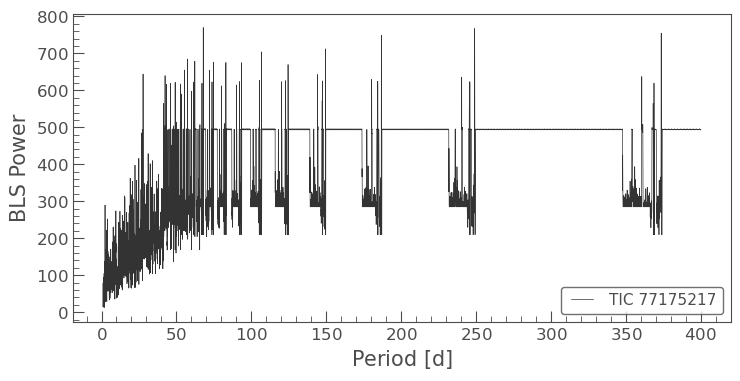

In [8]:
# Create array of periods to search
period = np.linspace(1, 400, 10000)
# Create a BLSPeriodogram
bls = lc_flat.to_periodogram(method='bls', period=period, frequency_factor=500);
bls.plot();

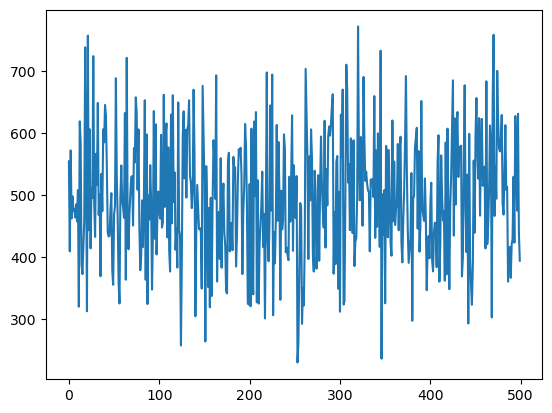

In [9]:
noise = np.random.normal(500, 100, 500)
plt.plot(noise)

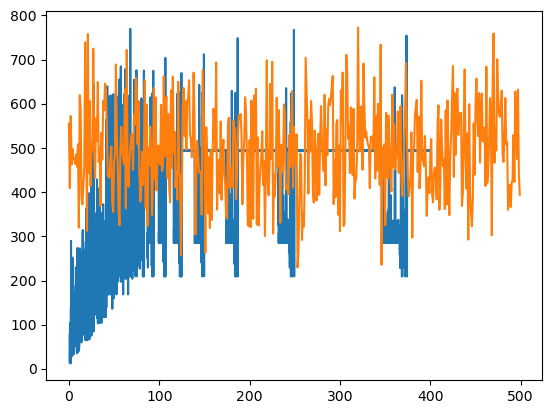

In [10]:
plt.plot(bls.period,bls.power)
plt.plot(noise)

In [11]:
bls.period_at_max_power.value


67.91899189918992

In [12]:
planet_period = bls.period_at_max_power
planet_t0 = bls.transit_time_at_max_power
planet_dur = bls.duration_at_max_power

# Check the value for period
planet_period

<Quantity 67.9189919 d>

In [13]:
planet_t0.value

1412.0802860684396

In [14]:
planet_period.value

67.91899189918992

In [15]:
bls.depth_at_max_power

<Quantity 0.00056871>

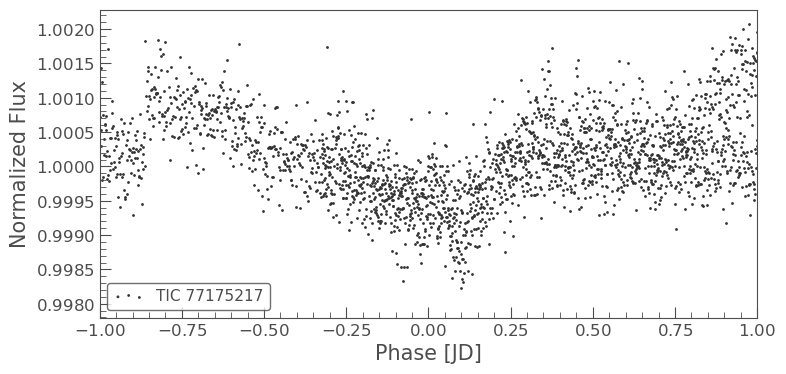

In [16]:
ax = lc_flat.fold(period=planet_period, epoch_time=planet_t0).scatter()
ax.set_xlim(-1, 1);

In [17]:
# Create a cadence mask using the BLS parameters
planet_mask = bls.get_transit_mask(period=planet_period,
                                     transit_time=planet_t0,
                                     duration=planet_dur)

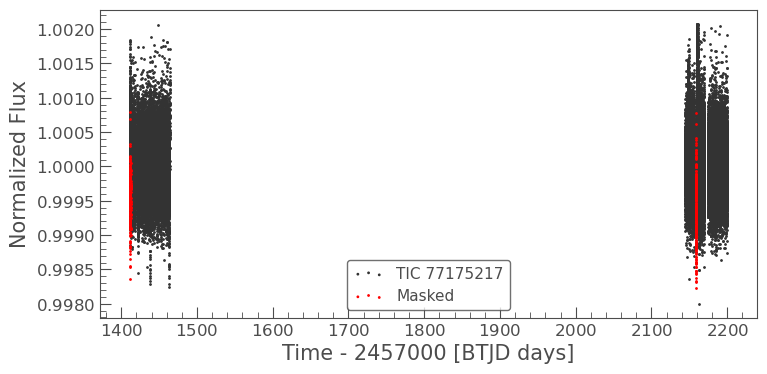

In [18]:
masked_lc = lc_flat[~planet_mask]
ax = masked_lc.scatter();
lc_flat[planet_mask].scatter(ax=ax, c='r', label='Masked');
#ax.set_xlim(2783.5,2784);

In [19]:
# Create a BLS model using the BLS parameters
planet_model = bls.get_transit_model(period=planet_period,
                                       transit_time=planet_t0,
                                       duration=planet_dur)

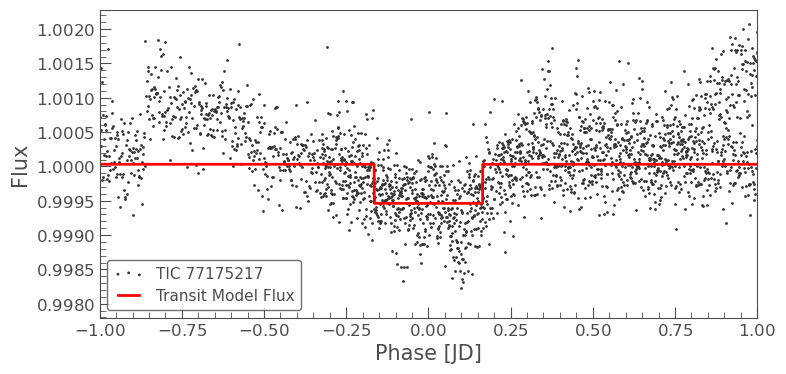

In [20]:
ax = lc_flat.fold(planet_period, planet_t0).scatter()
planet_model.fold(planet_period, planet_t0).plot(ax=ax, c='r', lw=2)
ax.set_xlim(-1, 1);

In [21]:
#lc_flat.interact_bls()

Extra planet signals?

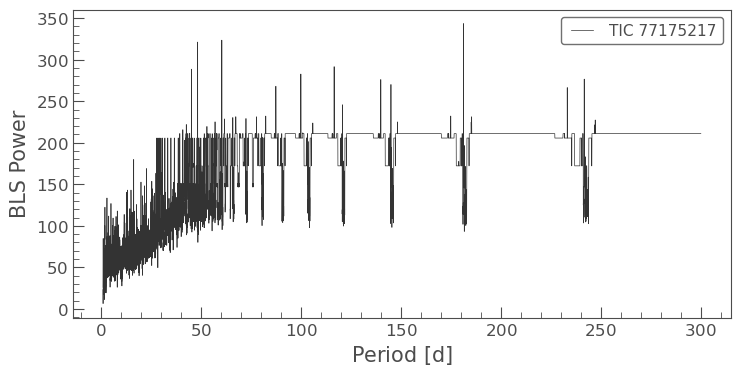

In [21]:
period2 = np.linspace(1, 300, 10000)
bls2 = masked_lc.to_periodogram('bls', period=period2, frequency_factor=500)
bls2.plot();

In [22]:
planet_c_period = bls2.period_at_max_power
planet_c_t0 = bls2.transit_time_at_max_power
planet_c_dur = bls2.duration_at_max_power

# Check the value for period
planet_c_period

<Quantity 181.25522552 d>

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

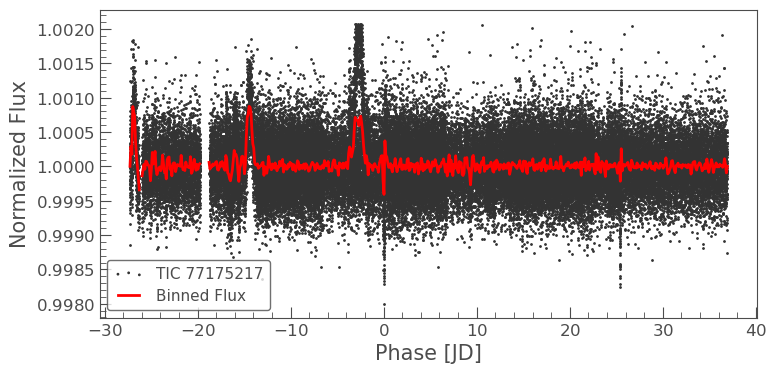

In [23]:
ax = masked_lc.fold(planet_c_period, planet_c_t0).scatter()
masked_lc.fold(planet_c_period, planet_c_t0).bin(.1).plot(ax=ax, c='r', lw=2,
                                                          label='Binned Flux')
#ax.set_xlim(-5, 5);

In [24]:
planet_c_model = bls.get_transit_model(period=planet_c_period,
                                       transit_time=planet_c_t0,
                                       duration=planet_c_dur)

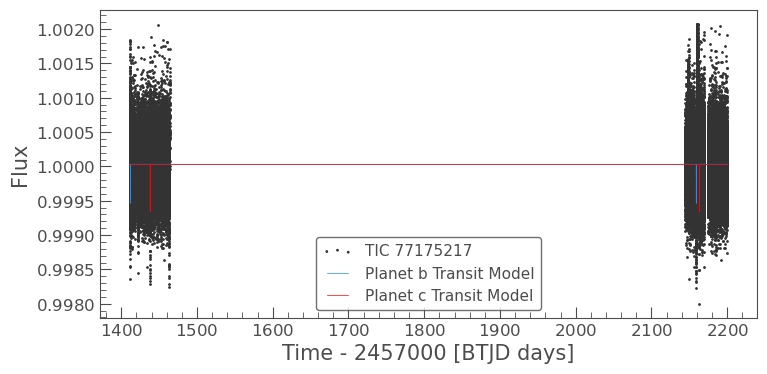

In [25]:
ax = lc_flat.scatter();
planet_model.plot(ax=ax, c='dodgerblue', label='Planet b Transit Model');
planet_c_model.plot(ax=ax, c='r', label='Planet c Transit Model');

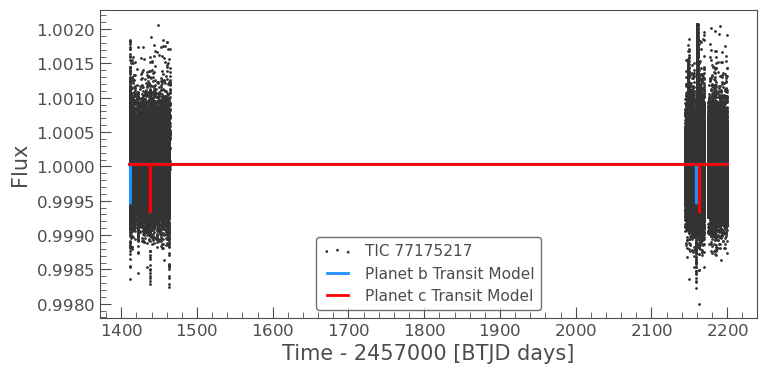

In [26]:
ax = lc_flat.scatter();
planet_model.plot(ax=ax, c='dodgerblue', label='Planet b Transit Model',lw=2);
planet_c_model.plot(ax=ax, c='r', label='Planet c Transit Model',lw=2);
#ax.set_xlim(1410,1415)

#ax.set_xlim(1435,1440)

(1410.0, 1415.0)

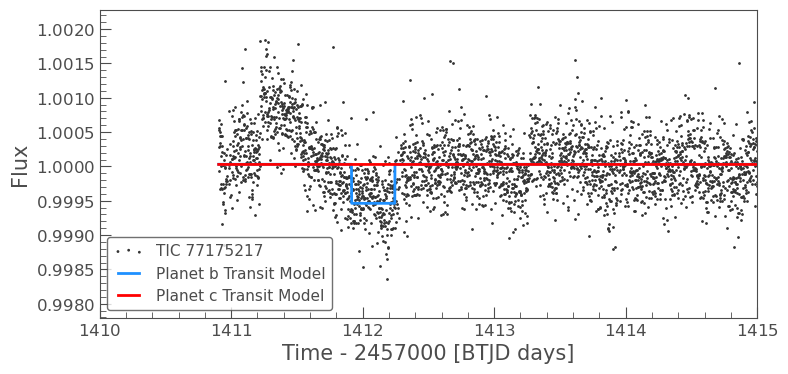

In [27]:
ax = lc_flat.scatter();
planet_model.plot(ax=ax, c='dodgerblue', label='Planet b Transit Model',lw=2);
planet_c_model.plot(ax=ax, c='r', label='Planet c Transit Model',lw=2);
ax.set_xlim(1410,1415)

#ax.set_xlim(1435,1440)

(1438.0, 1440.0)

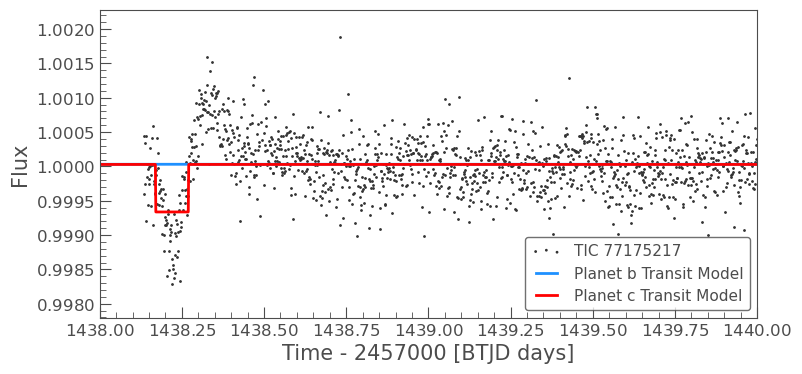

In [28]:
ax = lc_flat.scatter();
planet_model.plot(ax=ax, c='dodgerblue', label='Planet b Transit Model',lw=2);
planet_c_model.plot(ax=ax, c='r', label='Planet c Transit Model',lw=2);
ax.set_xlim(1438,1440)

#ax.set_xlim(1435,1440)

(2157.0, 2165.0)

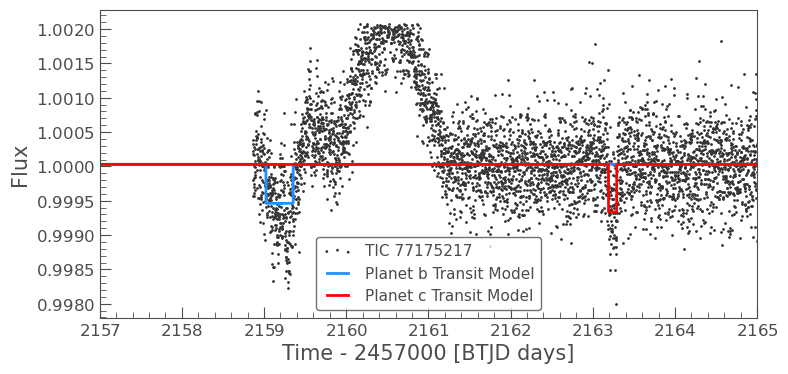

In [29]:
ax = lc_flat.scatter();
planet_model.plot(ax=ax, c='dodgerblue', label='Planet b Transit Model',lw=2);
planet_c_model.plot(ax=ax, c='r', label='Planet c Transit Model',lw=2);
ax.set_xlim(2157,2165)

#ax.set_xlim(1435,1440)